## Result 2: VSI
Vertical signal integrity (VSI) was accessed using `ovrl.py` (See `Ovrlpy_all_transcripts.ipynb`).  

This notebook focuses on the VSI map at Bregma = -0.24 and VSI differences between MOD_wm and MOD_gm.

In [39]:
import sys
import os
from pathlib import Path
sys.path.append(os.path.abspath("../src"))

import importlib
import utils
import plot

importlib.reload(utils)
importlib.reload(plot)

from utils import load_merfish_signal_df, load_banksy_result, load_merfish_data, load_boundaries_data
from utils import extract_cell_vsi
from plot import plot_VSI_map, plot_vsi_with_named_squares, plot_VSI_region, plot_vsi_distribution_comparison, plot_normalized_histogram, plot_vsi_qqplot
from plot import CM, SAVE_FIG

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import display
import numpy as np

In [40]:
fig_path = Path("../data/results/R2")

### data

#### Signals in the Tissue Section

In [41]:
MERFISH_data_folder_path = Path("../data/mouse_hypothalamus/MERFISH/")

In [42]:
signal_coordinate_df, coordinate_x_m, coordinate_y_m = load_merfish_signal_df(MERFISH_data_folder_path/"merfish_barcodes_example.csv")

#### Results of Ovrlpy

results:  
- signal integrity  
- signal strength  

In [43]:
ovrlpy_result_folder = Path("../data/results/VSI")

In [44]:
signal_integrity = np.loadtxt(ovrlpy_result_folder/"SignalIntegrity.txt")
signal_strength = np.loadtxt(ovrlpy_result_folder/"SignalStrength.txt")

#### Results of BANKSY

In [45]:
banksy_folder_path = Path("../data/banksy_results/")

In [46]:
banksy_result = load_banksy_result(banksy_folder_path/"banksy_cluster.txt", coordinate_x_m, coordinate_y_m)

#### Segmentation Dataset

In [47]:
merfish_data = load_merfish_data(MERFISH_data_folder_path / "merfish_all_cells.csv", 
                                 banksy_result, coordinate_x_m, coordinate_y_m, 
                                 animal_id=1, bregma_value=-0.24)

#### Cell boundaries

In [48]:
boundaries_df = load_boundaries_data(MERFISH_data_folder_path/'cellboundaries_example_animal.csv', 
                                     merfish_data, coordinate_x_m, coordinate_y_m)

#### MOD
BANKSY cluster:  
- 7: MOD_wm  
- 8: MOD_gm  

In [49]:
# boundaries, MOD
MOD_wm_boundaries = boundaries_df[boundaries_df['banksy'] == 7]
MOD_gm_boundaries = boundaries_df[boundaries_df['banksy'] == 8]

### VSI across the slice
Main findings:  
- Lower VSI at cell borders
- May cause false cell identification

#### overall

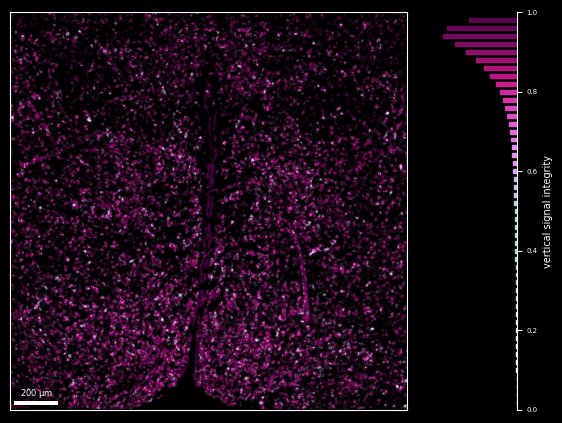

In [50]:
VSImap = plot_VSI_map(
    integrity = signal_integrity,
    strength = signal_strength,
    signal_threshold=3.0,
    figure_height=11*CM,
    cmap="BIH",
    side_display="hist", # "hist", "colorbar", or None
    plot_rasterized=True
)

display(VSImap)

In [51]:
VSImap.savefig(fig_path/"VSIhist.pdf", **SAVE_FIG)

#### cell level

In [52]:
cell_integrity, cell_strength = extract_cell_vsi(
    boundary_df=boundaries_df, 
    integrity=signal_integrity,
    strength=signal_strength,
    integrity_size=1800
)

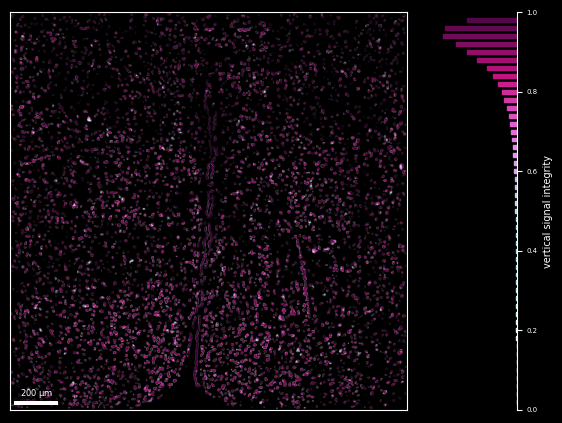

In [53]:
cell_VSI = plot_VSI_map(
    integrity = cell_integrity,
    strength = cell_strength,
    signal_threshold=3.0,
    figure_height=11*CM,
    cmap="BIH",
    side_display="hist",
    plot_rasterized=True
)

display(cell_VSI)

#### ROI for findings
ROIs show the low vsi at borders and false cell identification

In [54]:
regions = [
    {"x": 400, "y": 1190, "name": "R1"},
    {"x": 1350, "y": 950, "name": "R2"},
    {"x": 50, "y": 440, "name": "R3"},
    {"x": 1400, "y": 250, "name": "R4"},
]

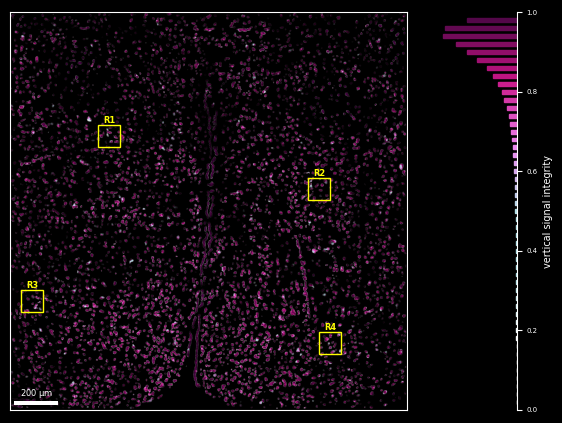

In [55]:
VSI_ROI = plot_vsi_with_named_squares(cell_integrity, cell_strength, 
    signal_threshold=3.0,
    figure_height=11*CM,
    cmap="BIH",
    # side_display='colorbar',
    side_display='hist',
    named_squares=regions,
    plot_rasterized=True)

display(VSI_ROI)

In [56]:
VSI_ROI.savefig(fig_path/"VSI_ROI.png", **SAVE_FIG)

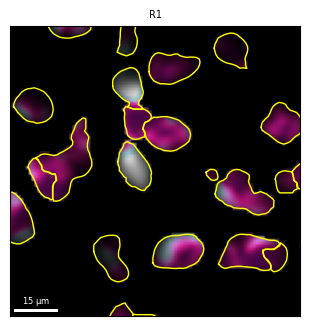

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(8*CM, 8*CM), sharex=True, sharey=True, constrained_layout=True)
plot_VSI_region(integrity=cell_integrity, strength=cell_strength,
             plot_boundary=True, boundary_df=boundaries_df, boundary_width=1,
             side_display=None, signal_threshold=3.0, figure_height=8*CM,
             x_range=[400, 500], y_range=[1190, 1290],
             title="R1", scale_loc='lower left', ax=ax)

plt.savefig(fig_path/"ROI1.png", **SAVE_FIG)
plt.show()

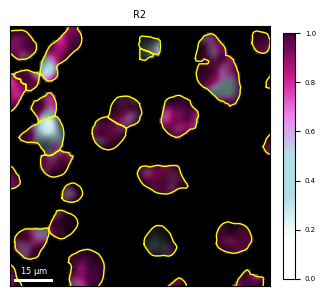

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(8*CM, 8*CM), sharex=True, sharey=True, constrained_layout=True)
plot_VSI_region(integrity=cell_integrity, strength=cell_strength,
             plot_boundary=True, boundary_df=boundaries_df, boundary_width=1,
             side_display='colorbar', signal_threshold=3.0, figure_height=8*CM,
             x_range=[1350, 1450], y_range=[950, 1050],
             title="R2", scale_loc='lower left', ax=ax)
plt.savefig(fig_path/"ROI2.png", **SAVE_FIG)
plt.show()

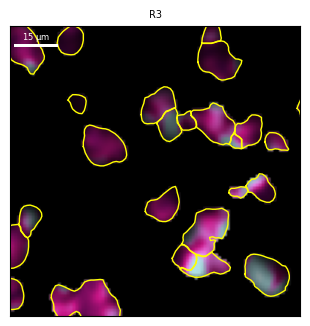

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(8*CM, 8*CM), sharex=True, sharey=True, constrained_layout=True)
plot_VSI_region(integrity=cell_integrity, strength=cell_strength,
             plot_boundary=True, boundary_df=boundaries_df, boundary_width=1,
             side_display=None, signal_threshold=3.0, figure_height=8*CM,
             x_range=[50, 150], y_range=[440, 540],
             title="R3", scale_loc='upper left', ax=ax)

plt.savefig(fig_path/"ROI3.png", **SAVE_FIG)
plt.show()

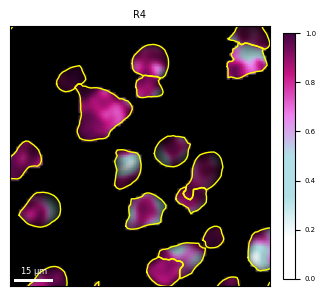

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(8*CM, 8*CM), sharex=True, sharey=True, constrained_layout=True)
plot_VSI_region(integrity=cell_integrity, strength=cell_strength,
             plot_boundary=True, boundary_df=boundaries_df, boundary_width=1,
             side_display='colorbar', signal_threshold=3.0, figure_height=8*CM,
             x_range=[1400, 1500], y_range=[250,350],
             title="R4", scale_loc='lower left', ax=ax)

plt.savefig(fig_path/"ROI4.png", **SAVE_FIG)
plt.show()

### VSI in MODs
compare the VSI values in MOD_wm and MOD_gm  
- MOD_gm shows lower VSI

#### MOD_wm vs. MOD_gm

In [61]:
MOD_wm_int, MOD_wm_str = extract_cell_vsi(MOD_wm_boundaries, signal_integrity, signal_strength)
MOD_gm_int, MOD_gm_str = extract_cell_vsi(MOD_gm_boundaries, signal_integrity, signal_strength)

d:\00Study\Thesis\thesiscode\src\plot.py:473: UserWarning: The figure layout has changed to tight
  
d:\miniconda\envs\ovrlpy\Lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
d:\miniconda\envs\ovrlpy\Lib\site-packages\scipy\interpolate\_interpolate.py:482: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


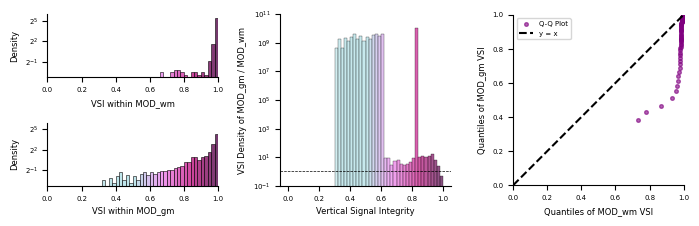

In [62]:
fig = plt.figure(figsize=(18*CM, 6*CM), constrained_layout=True)
gs = gridspec.GridSpec(2, 3, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[:, 1])
ax4 = fig.add_subplot(gs[:, 2])

vals1, bins1, vals2, bins2 = plot_vsi_distribution_comparison(
    cell_integrity_1=MOD_wm_int,
    cell_strength_1=MOD_wm_str,
    cell_integrity_2=MOD_gm_int,
    cell_strength_2=MOD_gm_str,
    signal_threshold=3.0,
    figure_height=6*CM,
    cmap="BIH",
    ylim=(1e-1,64),
    ax=[ax1, ax2],
)

plot_normalized_histogram(vals1, vals2, bins=bins1, epsilon=1e-10, ylim=(1e-1, 1e11), ax=ax3)

plot_vsi_qqplot(vals1, bins1, vals2, bins2,
                xlab="Quantiles of MOD_wm VSI",
                ylab="Quantiles of MOD_gm VSI",
                ax=ax4)

plt.savefig(fig_path/"MODsVSI.pdf", **SAVE_FIG)
plt.show()